# 基于心理测评量表预测抑郁症和焦虑症

简介：该项目为评估疫情期间工作人员的心理状况而收集的数据，目前期望用于预测被试的抑郁症和焦虑症，并且基于筛查的目的，分析false positive被试为高危人群的可能性。处理思路如下：

1.读取数据，观察特征及其分布

2.分析缺失情况，处理缺失值

3.异常值处理

4.对分类变量进行哑编码

5.用随机森林进行重要特征筛选

6.重采样对不均衡数据进行处理

7.构建XGBOOST模型，并进行建模分析预测

基于本项目合理顺序为：
1.读取数据;
2.对分类变量进行哑编码（正则化+one-hot编码？）；
3.用随机森林进行重要特征筛选;
4.观察特征及其分布；
5.重采样对不均衡数据进行处理；
6.xgboost进行分析预测

In [1]:
#导入工具包
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
from xgboost import plot_importance
import matplotlib.pyplot as plt
from graphviz import Digraph
from scipy import stats
import pydot
import numpy as np
import pandas as pd
import xlwt
import warnings
import time
warnings.filterwarnings("ignore")

In [3]:
#1.读取数据
D = r'data\DdataP.xlsx'
A = r'data\AdataP.xlsx'
DA = r'data\DAdata.xlsx'
PA = r'data\PAdata.xlsx'
path_list = [D,A,DA,PA]
def data_load(file):
    data = pd.read_excel(file)
    df = data.drop(['ConsensusofPTA','总','失眠','焦虑症','抑郁症','心理障碍',
                    'SRQtotalScore','ISIT','PHQ9TotalScore','GAD7TotalScore'],axis=1)
    return df

In [4]:
def muti_data_load(path_list):
    muti_data = []
    for path in path_list:
        df = data_load(path)
#         df = df.drop(['SSQobjectivesupport','SSQsubjecttivesupport','SSQUsedofspport',
#                      'SQDCPRResponsetime','CDRISCToughnessof','CDRISCStrengthof',
#                      'CDRISCOptimismof','CDRISCResponsetimeof'],axis=1)
        muti_data.append(df)
    return muti_data


In [5]:
path_list = [D,A,DA,PA]
muti_data = muti_data_load(path_list)

In [129]:
#一、step1:连续变量统计分析
variable = 'Occupation'
for i in range(3):
    df = muti_data[i]
    print(df[variable].groupby(df['target']).describe())
#     a = df[df['target']==1]
#     df = df[df['target']==0]
#     u = df[variable].mean()  # 计算均值
#     std = df[variable].std()  # 计算标准差
    
# #     print(stats.kstest(df[variable], 'norm', (u, std)))

#     df2=df[df['target']==0][variable]
#     df3=df[df['target']==1][variable]
#     leveneTestRes=stats.levene(df2,df3,center='median')


#     print(leveneTestRes)#正态分布
# #     print(stats.mannwhitneyu(df2, df3))#非正态分布

          count      mean       std  min  25%  50%  75%  max
target                                                      
0       15935.0  3.416128  1.663322  1.0  2.0  3.0  4.0  9.0
1        4632.0  2.439119  1.317362  1.0  1.0  2.0  3.0  9.0
          count      mean       std  min  25%  50%  75%  max
target                                                      
0       15935.0  3.416128  1.663322  1.0  2.0  3.0  4.0  9.0
1        1219.0  2.778507  1.396158  1.0  2.0  3.0  4.0  9.0
          count      mean       std  min  25%  50%  75%  max
target                                                      
0       15935.0  3.416128  1.663322  1.0  2.0  3.0  4.0  9.0
1        8055.0  2.091993  1.235335  1.0  1.0  2.0  3.0  9.0


In [8]:
#一、step2:离散变量统计分析
variable = 'Occupation'
for i in range(3):
    df = muti_data[i]
# print(df[variable].groupby(df['target']).describe())
    dummies=pd.get_dummies(df[variable],prefix=variable)
    print(dummies.shape[1])
    a = df[df['target']==0]

    cross_table = pd.crosstab(df['target'], df[variable], margins=True)
    print(cross_table)
    print('chisq = %6.4f\n p-value = %6.4f\n dof = %i\n expected_freq = %s' %stats.chi2_contingency(cross_table))
    for j in range(1,dummies.shape[1]+1):
        print('v{}'.format(j),len(a[a[variable]== j])/len(a)*100)


8
Occupation     1     2     3     4     5     6   7    8    All
target                                                        
0            997  4140   737  1406  1858  6593  22  182  15935
1            372  1472   271   317   658  1429   7  106   4632
All         1369  5612  1008  1723  2516  8022  29  288  20567
chisq = 243.6136
 p-value = 0.0000
 dof = 16
 expected_freq = [[1.06068046e+03 4.34809258e+03 7.80983128e+02 1.33495430e+03
  1.94935868e+03 6.21532406e+03 2.24687606e+01 2.23138037e+02
  1.59350000e+04]
 [3.08319541e+02 1.26390742e+03 2.27016872e+02 3.88045704e+02
  5.66641319e+02 1.80667594e+03 6.53123936e+00 6.48619633e+01
  4.63200000e+03]
 [1.36900000e+03 5.61200000e+03 1.00800000e+03 1.72300000e+03
  2.51600000e+03 8.02200000e+03 2.90000000e+01 2.88000000e+02
  2.05670000e+04]]
v1 6.256667712582366
v2 25.980545967994978
v3 4.62503922183872
v4 8.823344838406024
v5 11.659868214621902
v6 41.37433322874176
v7 0.13806087229369313
v8 1.1421399435205524
8
Occupation     1    

8
Occupation     1     2     3     4     5     6   7    8    All
target                                                        
0            997  4140   737  1406  1858  6593  22  182  15935
1            665  2282   561   475  1387  2449   2  234   8055
All         1662  6422  1298  1881  3245  9042  24  416  23990
chisq = 550.3144
 p-value = 0.0000
 dof = 16
 expected_freq = [[1.10395873e+03 4.26571780e+03 8.62177157e+02 1.24942622e+03
  2.15544289e+03 6.00601376e+03 1.59416424e+01 2.76321801e+02
  1.59350000e+04]
 [5.58041267e+02 2.15628220e+03 4.35822843e+02 6.31573781e+02
  1.08955711e+03 3.03598624e+03 8.05835765e+00 1.39678199e+02
  8.05500000e+03]
 [1.66200000e+03 6.42200000e+03 1.29800000e+03 1.88100000e+03
  3.24500000e+03 9.04200000e+03 2.40000000e+01 4.16000000e+02
  2.39900000e+04]]
v1 8.255741775294847
v2 28.330229671011793
v3 6.964618249534451
v4 5.896958410924891
v5 17.219118559900686
v6 30.403476101800127
v7 0.024829298572315334
v8 2.905027932960894
8
Occupation     1     2     3     4     5     6   7    8    All
target                                                        
0            997  4140   737  1406  1858  6593  22  182  15935
1            665  2282   561   475  1387  2449   2  234   8055
All         1662  6422  1298  1881  3245  9042  24  416  23990
chisq = 550.3144
 p-value = 0.0000
 dof = 16
 expected_freq = [[1.10395873e+03 4.26571780e+03 8.62177157e+02 1.24942622e+03
  2.15544289e+03 6.00601376e+03 1.59416424e+01 2.76321801e+02
  1.59350000e+04]
 [5.58041267e+02 2.15628220e+03 4.35822843e+02 6.31573781e+02
  1.08955711e+03 3.03598624e+03 8.05835765e+00 1.39678199e+02
  8.05500000e+03]
 [1.66200000e+03 6.42200000e+03 1.29800000e+03 1.88100000e+03
  3.24500000e+03 9.04200000e+03 2.40000000e+01 4.16000000e+02
  2.39900000e+04]]
v1 8.255741775294847
v2 28.330229671011793
v3 6.964618249534451
v4 5.896958410924891
v5 17.219118559900686
v6 30.403476101800127
v7 0.024829298572315334
v8 2.905027932960894
8
Occupation     1     2     3     4     5     6   7    8    All
target                                                        
0            997  4140   737  1406  1858  6593  22  182  15935
1            665  2282   561   475  1387  2449   2  234   8055
All         1662  6422  1298  1881  3245  9042  24  416  23990
chisq = 550.3144
 p-value = 0.0000
 dof = 16
 expected_freq = [[1.10395873e+03 4.26571780e+03 8.62177157e+02 1.24942622e+03
  2.15544289e+03 6.00601376e+03 1.59416424e+01 2.76321801e+02
  1.59350000e+04]
 [5.58041267e+02 2.15628220e+03 4.35822843e+02 6.31573781e+02
  1.08955711e+03 3.03598624e+03 8.05835765e+00 1.39678199e+02
  8.05500000e+03]
 [1.66200000e+03 6.42200000e+03 1.29800000e+03 1.88100000e+03
  3.24500000e+03 9.04200000e+03 2.40000000e+01 4.16000000e+02
  2.39900000e+04]]
v1 8.255741775294847
v2 28.330229671011793
v3 6.964618249534451
v4 5.896958410924891
v5 17.219118559900686
v6 30.403476101800127
v7 0.024829298572315334
v8 2.905027932960894

In [ ]:
KstestResult(statistic=0.16558954395978537, pvalue=9.60386918564241e-111)
KstestResult(statistic=0.13092344815694612, pvalue=1.1155370296157348e-18)
KstestResult(statistic=0.1400672694644316, pvalue=1.0917620164552238e-137)
KstestResult(statistic=0.14764822839280417, pvalue=9.71848631447346e-264)

In [6]:
#分层抽样（样本比例依然不均衡）

def train_test_sp(df, target, test_size = 0.2):
    """
    简单分层抽样
    基于 sklearn.model_selection.StratifiedShuffleSplit
    param data: 数据集
    param target: 分层拆分比例依据
    param test_size: 测试集比例 float
    """
    splitned = StratifiedShuffleSplit(n_splits= 1, test_size = test_size, random_state = 42)
    for train_index, test_index in splitned.split(data, data[target]):
            strat_train_set = data.loc[train_index]
            strat_test_set = data.loc[test_index]
    return  strat_train_set, strat_test_set

#下采样
def down_sample(df,percent):
    df1=df[df['target']==1]#正例
    df2=df[df['target']==0]##负例
    df3=df2.sample(frac=percent)##抽负例
    return pd.concat([df1,df3],ignore_index=True)

#上采样
def up_sample(df):
    df1=df[df['target']==1]#正例
    df2=df[df['target']==0]##负例
    df3=pd.concat([df1,df1,df1,df1,df1],ignore_index=True)
    return pd.concat([df2,df3],ignore_index=True)

def batch_data(df,sample_size):
    X = df.iloc[:, df.columns != 'target']
    y = df.iloc[:, df.columns == 'target']
    n_indices = np.array(y[y.target == 0].index)
    d_indices = np.array(y[y.target == 1].index)
    random_n_indices = np.random.choice(n_indices, sample_size, replace=False)  # 从negative_indices中选择出positive_number个数来，replace=false表没有重复替换的随机采样，也就是采出来的数据如果是一样的，不替换，也就是独立的。
    random_d_indices = np.random.choice(d_indices, sample_size, replace=False)
    random_n_indices = np.array(random_n_indices)
    random_d_indices = np.array(random_d_indices)
    under_sample_indices = np.concatenate([random_n_indices, random_d_indices]) # 把两个数组串联起来
    under_sample_data = df.iloc[under_sample_indices, :]  # 取出数据中标签对应的样本
    X = under_sample_data.iloc[:, under_sample_data.columns != 'target']  # 将取出的样本划分
    y = under_sample_data.iloc[:, under_sample_data.columns == 'target']  # 将取出的样本划分
#     print(X_sample)
#     X_sample = np.array(X_sample)
#     y_sample = np.array(y_sample).reshape(len(y_sample))

    return X,y

In [ ]:
#一、Step3 观察变量间相关性
#计算变量间相关系数

r1 = train_set.corr()
r1=abs(r1)# 取绝对值，只看相关程度 ，不关心正相关还是负相关
names = train_set.columns
fig = plt.figure() 
f,ax = plt.subplots(figsize=(20,20)) #图片大小为20*20
ax = sns.heatmap(r1, linewidths=0.05,vmax=1, vmin=0 ,annot=True,annot_kws={'size':6,'weight':'bold'})
#热力图参数设置（相关系数矩阵，颜色，每个值间隔等）
#ticks = numpy.arange(0,16,1) #生成0-16，步长为1 
plt.xticks(np.arange(65)+0.5,names) #横坐标标注点
plt.yticks(np.arange(65)+0.5,names) #纵坐标标注点
ax.set_title('Characteristic correlation')#标题设置
plt.savefig(r'work\results\correlation.tif',dpi=300)


<Figure size 432x288 with 0 Axes>

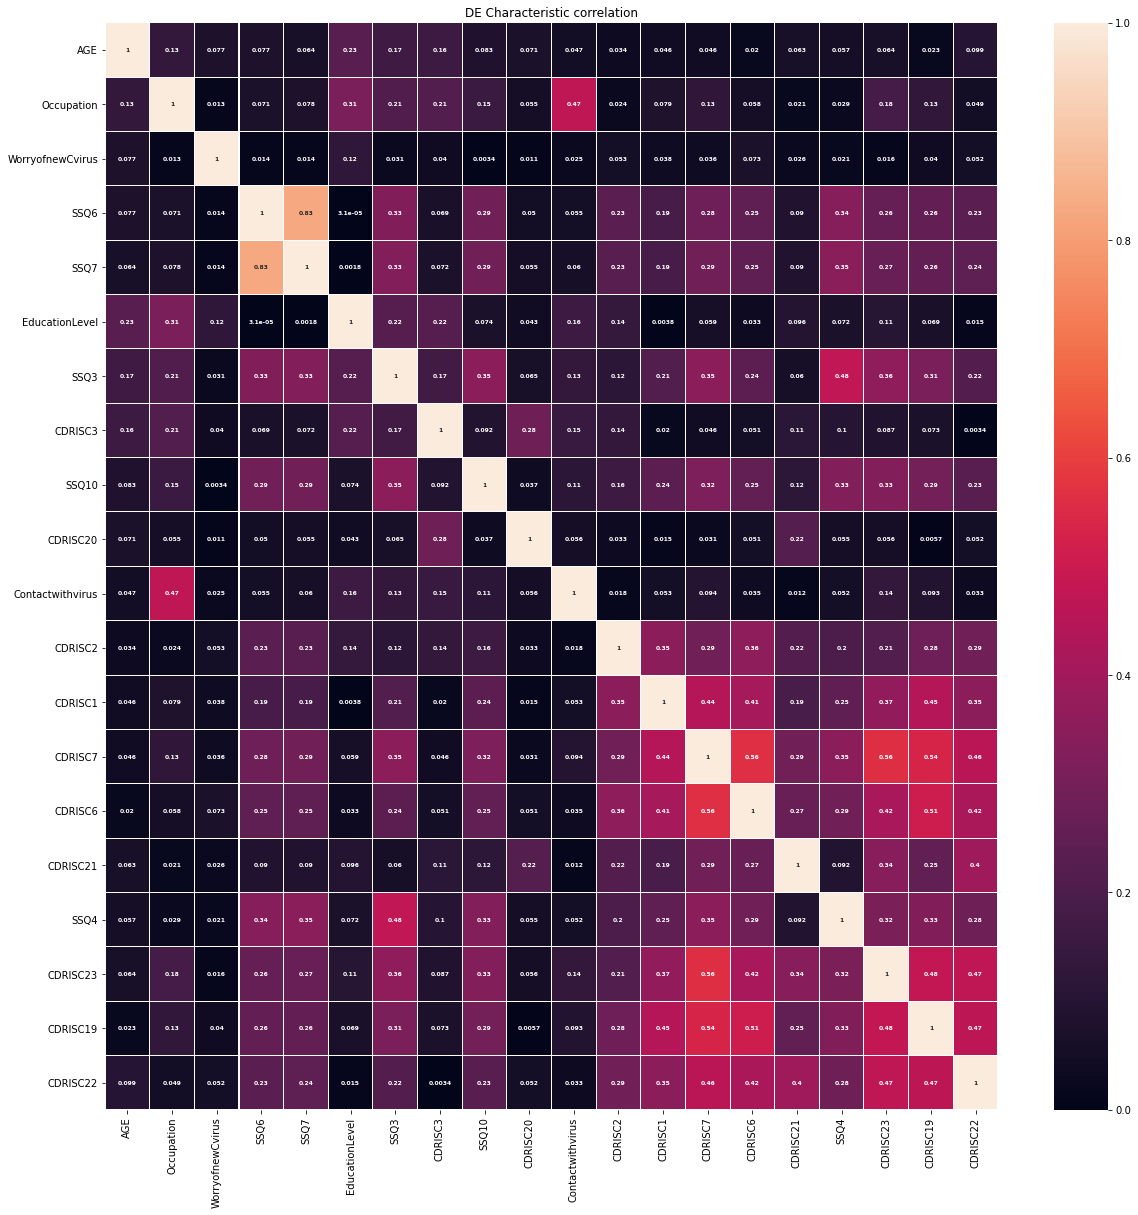

<Figure size 432x288 with 0 Axes>

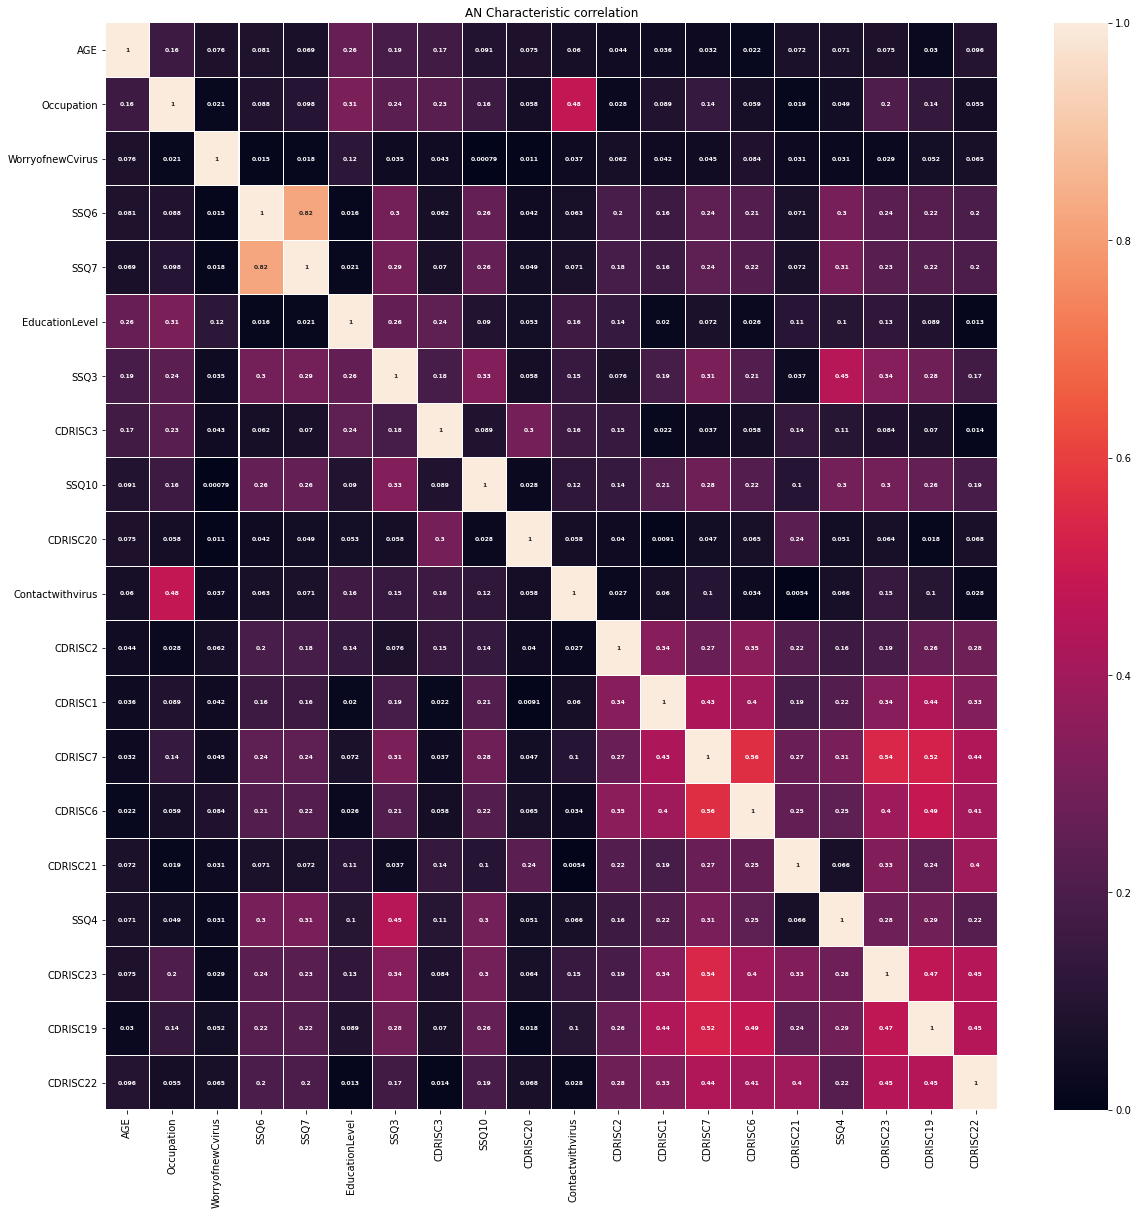

<Figure size 432x288 with 0 Axes>

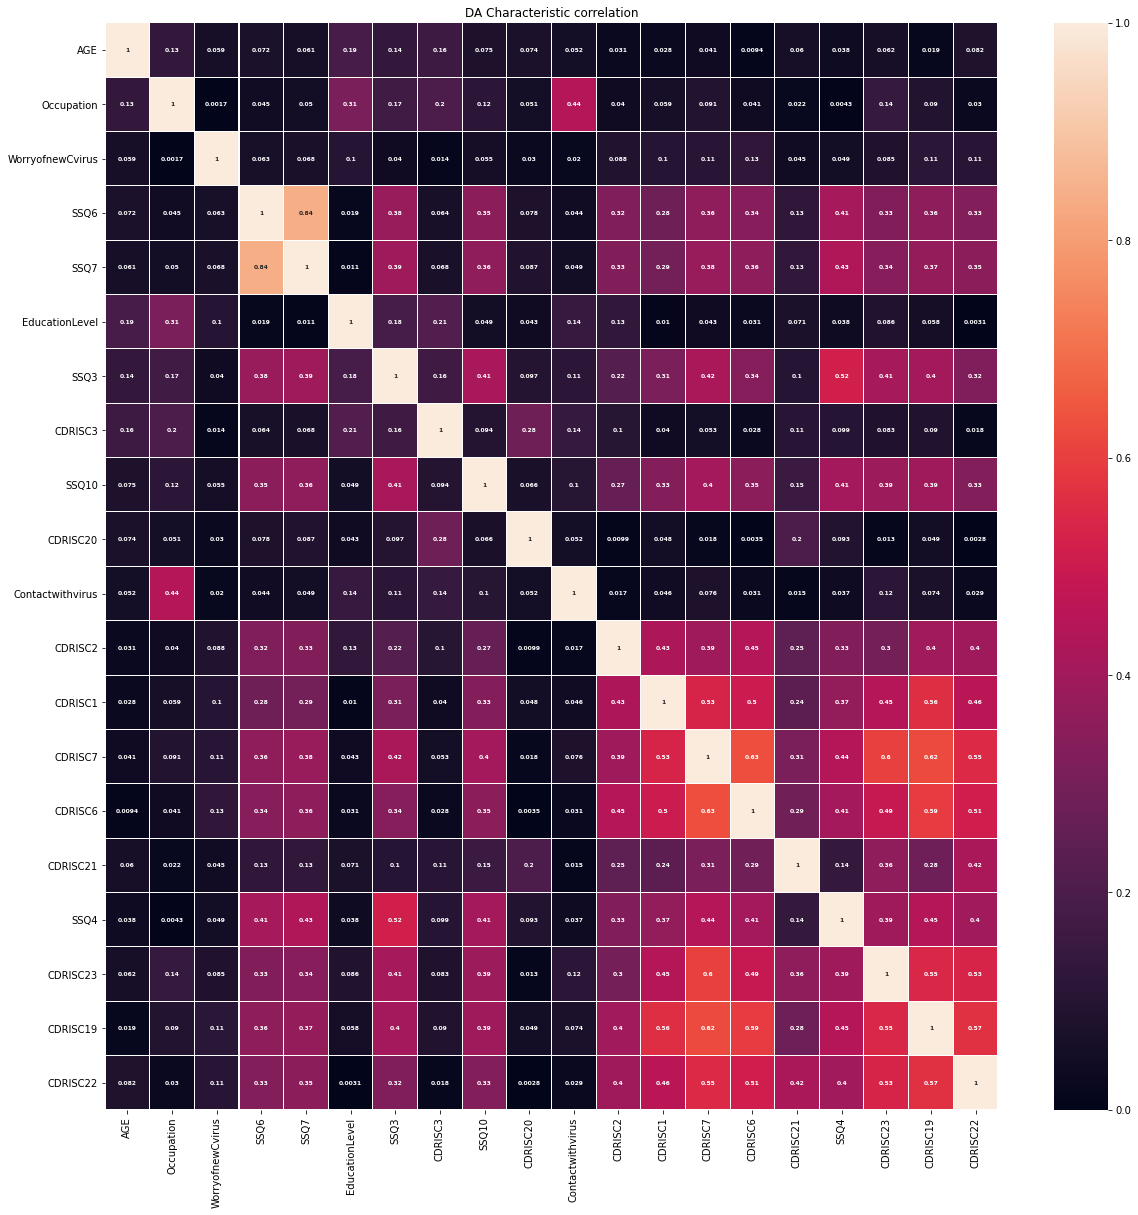

In [26]:
#分析筛选变量间的相关性
name_list = ['DE','AN','DA']
for i in range(3):
    
    data_name = name_list[i]
    df = muti_data[i]
    df = data_selected(df,selected_feat_names)
    X = df.iloc[:, df.columns != 'target']
#     rho,pval=stats.spearmanr(X.SSQ6,X.SSQ7)
#     print(rho,pval)
#     print(stats.pearsonr(X.WorryofnewCvirus,X.CDRISC3))
    r1 = X.corr()
    r1=abs(r1)# 取绝对值，只看相关程度 ，不关心正相关还是负相关
    names = X.columns
    fig = plt.figure() 
    f,ax = plt.subplots(figsize=(20,20)) #图片大小为20*20
    ax = sns.heatmap(r1, linewidths=0.05,vmax=1, vmin=0 ,annot=True,annot_kws={'size':6,'weight':'bold'})
    #热力图参数设置（相关系数矩阵，颜色，每个值间隔等）
    #ticks = numpy.arange(0,16,1) #生成0-16，步长为1 
    plt.xticks(np.arange(20)+0.5,names) #横坐标标注点
    plt.yticks(np.arange(20)+0.5,names) #纵坐标标注点
    ax.set_title(f'{data_name} Characteristic correlation')#标题设置
    plt.savefig(f'work/results/{data_name}_corr.png',dpi=300)

经变量计算得来的变量共线性明显，需要删除，

In [ ]:
#计算熵，观察分类变量的相关系数

In [7]:
#对分类变量进行哑编码
def dummy_encode(df,filed,a):
    dummies=pd.get_dummies(df[filed],prefix=a)
    len=dummies.shape[1]-1
    a= dummies.iloc[:,0:len]
    b=pd.concat([df, a], axis=1)
    del b[filed]
    return b

In [ ]:
#基于随机森林的特征选择
def feature_selection(X_train,y_train):
    selected_feat_names=set()
    for i in range(10):                           #这里我们进行十次循环取交集
        tmp = set()
        rfc = RandomForestClassifier(n_jobs=-1)
        rfc.fit(X_train, y_train)

        #print("training finished")

        importances = rfc.feature_importances_
        indices = np.argsort(importances)[::-1]   # 降序排列
        S={}
        for f in range(X_train.shape[1]):
            if  importances[indices[f]] >=0.001:
                tmp.add(X_train.columns[indices[f]])
                S[X_train.columns[indices[f]]]=importances[indices[f]]
                #print("%2d) %-*s %f" % (f + 1, 30, X.columns[indices[f]], importances[indices[f]]))
        selected_feat_names |= tmp
        imp_fea=pd.Series(S)
    return selected_feat_names,imp_fea


In [7]:
def feature_selected_data(X_train,y_train,X_test,y_test,selected_feat_names): 
    train_set = pd.concat([X_train,y_train],axis=1)
    test_set = pd.concat([X_test,y_test],axis=1)
    train_new=train_set[['target']]
    test_new=test_set[['target']]

    for i in selected_feat_names:
        train_new[i]=train_set[i]
        try :
            test_new[i]=test_set[i]
        except Exception :
            del train_new[i]

    return train_new,test_new

def data_selected(df,selected_feat_names): 

#     selected_feat_names = tops['var'].tolist()
    df_new = df[['target']]
    for i in selected_feat_names:
        df_new[i]=df[i]


    return df_new

In [ ]:
#二、预测分类

处理imbalance数据：欠采样

train_df  (1,0):(6.20580083499,93.794199165)
test_df  (1,0):(6.20075780357,93.7992421964)
正例：12382 负例：187141
抽样比例：25%
发生率为：21%

Xgboost 进行机器学习

In [342]:
##定义xgb模型参数
param = {}
# use logistic regression loss
param['objective'] = 'binary:logistic'
# scale weight of positive examples
param['scale_pos_weight'] = 1
param['bst:eta'] = 0.2
param['bst:max_depth'] = 6
param['eval_metric'] = 'logloss'
param['silent'] = 1
param['nthread'] = 10
Threshold=0.5

def xgb_model(name,X_train,y_train,X_test,y_test,save=True,dpin=100): 
    scaler=StandardScaler()
    scaler.fit(X_train)#利用训练集计算标准化的参数
    X_train=scaler.transform(X_train)#利用上面计算的参数标准化训练集和测试集
    X_test=scaler.transform(X_test)
    model = XGBClassifier(objective='binary:logistic')
    model.fit(X_train,y_train)
    y_test_pre = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    confusion_matrix_model = confusion_matrix(y_test, y_test_pre)
    accuracy = metrics.accuracy_score(y_test, y_test_pre)
    test_auc = metrics.roc_auc_score(y_test,y_test_pre)
    feature_importance = model.feature_importances_
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    print(confusion_matrix(y_test,y_test_pre))
    print(classification_report(y_test,y_test_pre))
    print('AUC值：',test_auc)
    print(feature_importance)
    plot_importance(model)
    plt.show()
    plt.figure(figsize=(20, 20), dpi=dpin)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label=1)
    plt.plot(fpr, tpr, lw=5,label='ROC curve (area = %0.2f)' % test_auc)
    plt.plot([0, 1], [0, 1], '--', lw=5, color='red')
    plt.axis('square')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('False Positive Rate', fontsize=20)
    plt.ylabel('True Positive Rate', fontsize=20)
    plt.title('ROC Curve', fontsize=25)
    plt.legend(loc='lower right', fontsize=20)
    
    if save:
        plt.savefig(f'{name}model_roc.png')

    return plt

In [20]:
names = ['DE',
         'AN',
         'DA']

muti_data_list = [muti_data[0],
                 muti_data[1],
                 muti_data[2]]

sample_size_list = [4632,
                    1219,
                    8055]

colors = ['crimson',
          'mediumseagreen',
          'mediumpurple']

In [10]:
#构建多个ROC图像
def multi_data_roc(names, colors,sample_size_list, muti_data_list, save=True, dpin=100):
    """
    将多个数据的roc图输出到一张图上

    """
    plt.figure(figsize=(20, 20), dpi=dpin)

    for (name,df,sample_size,colorname) in zip(names,muti_data_list,sample_size_list,colors):
        df = df.drop(['SSQobjectivesupport','SSQsubjecttivesupport','SSQUsedofspport',
                         'SQDCPRResponsetime','CDRISCToughness','CDRISCStrength',
                         'CDRISCOptimism','CDRISCResponsetime'],axis=1)  
        X,y = batch_data(df,sample_size)
#         scaler=StandardScaler()
#         scaler.fit(X)#利用训练集计算标准化的参数http://localhost:8888/notebooks/venv/Depression_Anxiety_Classification/Depression_Anxiety_Classification.ipynb#
#         X=scaler.transform(X)#利用上面计算的参数标准化训练集和测试集
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=7)
        model = XGBClassifier(objective ='reg:squarederror')
        model.fit(X_train, y_train)
# 
        y_test_pre = model.predict(X_test)    
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        confusion_matrix_model = confusion_matrix(y_test, y_test_pre)

        print(classification_report(y_test, y_test_pre, target_names=['HC',name]))
#         print(classification_report(y_test, y_test_preds, target_names=['Healthy','Anxiety']))
#         return classification_report(y_test, y_test_preds, target_names=['Healthy','Anxiety'])
        
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label=1)
        plt.plot(fpr, tpr, lw=5, label='{} (AUC={:.2f})'.format(name, auc(fpr, tpr)), color=colorname)
        plt.plot([0, 1], [0, 1], '--', lw=5, color='grey')
        plt.axis('square')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.xlabel('False Positive Rate', fontsize=20)
        plt.ylabel('True Positive Rate', fontsize=20)
        plt.title('ROC Curve', fontsize=25)
        plt.legend(loc='lower right', fontsize=20)

    if save:
        plt.savefig('multi_data_roc.png')

    return plt

In [11]:
##将目标变量提到最后一列
variables = ['target','AGE','EducationLevel']
def moved_variables(data,variables):
    for variable in variables:
        Y=df[variable]
        del df[variable]
        df[variable]=Y
    return Y

In [14]:
#类别变量哑编码
def terms_generate(df):
    terms = []
    for i in range(len(df.columns)-2):|
        terms.append('df{}'.format(i))
    return terms

def delete_variables(df):
    df = df.drop(['SSQobjectivesupport','SSQsubjecttivesupport','SSQUsedofspport','SSQResponsetime',
             'DCPRResponsetime','CDRISCToughness','CDRISCStrength',
             'CDRISCOptimism','CDRISCResponsetime'],axis=1)
    return df

def data_dummy_variables(df):

    terms = terms_generate(df)
    terms[0] = df
    for i in range(len(df.columns)-3):
        terms[i+1]= dummy_encode(terms[i],terms[i].columns[0],terms[i].columns[0])
    return terms[-1]


In [513]:
#step1：多组数据交叉验证
# for i in range(4):
i=0
df = muti_data[i]
sample_size = sample_size_list[i]
df = df.drop(['SSQobjectivesupport','SSQsubjecttivesupport','SSQUsedofspport',
             'SQDCPRResponsetime','CDRISCToughness','CDRISCStrength',
             'CDRISCOptimism','CDRISCResponsetime'],axis=1)  
# df = moved_variables(df,variables)
# df = data_dummy_variables(df)
X,y = batch_data(df,sample_size)
#     scaler=StandardScaler()
#     scaler.fit(X)
#     X=scaler.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=7)
model = XGBClassifier(objective ='reg:squarederror')
model.fit(X_train, y_train)
kfold = KFold(n_splits=10, random_state=7,shuffle=True)
results = cross_val_score(model, X, y, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
# xgb_model(name,X_train,y_train,X_test,y_test)
#     scaler=StandardScaler()
#     scaler.fit(X_train)#利用训练集计算标准化的参数http://localhost:8888/notebooks/venv/Depression_Anxiety_Classification/Depression_Anxiety_Classification.ipynb#
#     X_train=scaler.transform(X_train)#利用上面计算的参数标准化训练集和测试集
#     X_test=scaler.transform(X_test)
# model = XGBClassifier(objective='binary:logistic')
# kfold = KFold(n_splits=5, random_state=7,shuffle=True)
# results = cross_val_score(model, X, y, cv=kfold)
# print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))


Accuracy: 78.23% (1.18%)


In [ ]:
#step2 获得muti_data classification report 和ROC图
rocs = multi_data_roc(names, colors,sample_size_list, muti_data_list)

#重要特征可视化

DE：Accuracy: 78.05% (1.25%)
AN：Accuracy: 76.70% (2.25%)
DA：Accuracy: 88.73% (0.77%)
PA：Accuracy: 91.33% (0.46%)
PA_data:Accuracy: 92.17% (0.47%)(imbalanced)
D_data:Accuracy: 78.76% (0.93%)(balanced)
DA_data:Accuracy: 90.41% (0.43%)(imbalanced)
DA_data:Accuracy: 89.55% (0.58%)(balanced)
A_data:Accuracy: 78.83% (2.34%)(balanced)

In [331]:
#三、特征选择_嵌入法（Weight）

In [76]:
i=2
df = muti_data[i]
df = delete_variables(df)
sample_size = sample_size_list[i]
X,y = batch_data(df,sample_size)

In [77]:
name_list = ['DE','AN','DA']
data_name = name_list[i]

In [80]:
#Step1 获得目标准确率的model

from numpy import sort
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
from matplotlib.pyplot import MultipleLocator



X,y = batch_data(df,sample_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=7)
scaler=StandardScaler()
scaler.fit(X_train)#利用训练集计算标准化的参数http://localhost:8888/notebooks/venv/Depression_Anxiety_Classification/Depression_Anxiety_Classification.ipynb#
X_train=scaler.transform(X_train)#利用上面计算的参数标准化训练集和测试集
X_test=scaler.transform(X_test)
# fit model on all training data
model = XGBClassifier(objective ='reg:squarederror')
model.fit(X_train, y_train)
# make predictions for test data and evaluate
# kfold = KFold(n_splits=10, random_state=7,shuffle=True)
# results = cross_val_score(model, X, y, cv=kfold)
# print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# Fit model using each importance as a threshold


Accuracy: 88.80%


In [28]:
print(len(model.feature_importances_))
print(len(df.columns[:-1]))
# im=pd.DataFrame({'importance':model.feature_importances_,'var':df.columns[:-1]})

55
55


In [81]:
# step2 获取“gain”类型的特征筛选结果 
thresholds = sort(model.feature_importances_)
accuracy_list = []
feature_num = []
thresh_list =[]
selected_feature = []

for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X = selection.transform(X)
    # train model
    selection_model = XGBClassifier(objective ='reg:squarederror')
    kfold = KFold(n_splits=10, random_state=7,shuffle=True)
    results = cross_val_score(selection_model, select_X, y, cv=kfold)
#     selection_model.fit(select_X_train, y_train)
#     # eval model
#     select_X_test = selection.transform(X_test)
#     predictions = selection_model.predict(select_X_test)
#     accuracy = accuracy_score(y_test, predictions)
#     onece = cross_val_score(selection_model,select_X_test,y_test,cv=5).mean()
#     print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))
    temp = thresh
    accuracy_list.append(results.mean())
    feature_num.append(select_X.shape[1])
    thresh_list.append(temp)
#     selected_feature.append(select_X.columns)



In [60]:
#保存gain特征选择结果
a=[]
a.append(accuracy_list)
a.append(feature_num)
a.append(thresh_list)
headers = ['accuracy', 'feature_num', 'thresh']
result_sum = pd.DataFrame(dict(zip(headers, a)))

result_sum.to_excel(f'work/results/{data_name}_fs.xlsx')

In [86]:
X_train

array([[ 0.95403475,  0.30709608,  1.03737854, ..., -0.49734547,
        -1.0898493 , -1.14345105],
       [-1.04817985,  2.70763333, -0.96858314, ..., -1.43226211,
        -1.0898493 , -1.14345105],
       [-1.04817985,  0.05440794, -0.96858314, ...,  1.3724878 ,
         2.00725288,  2.34881889],
       ...,
       [ 0.95403475, -0.07193612, -0.96858314, ..., -0.49734547,
         0.76841201, -1.14345105],
       [-1.04817985, -0.70365645,  1.03737854, ...,  0.43757116,
        -0.47042887, -0.56140606],
       [-1.04817985,  0.93881641, -0.96858314, ..., -1.43226211,
        -1.0898493 , -1.14345105]])

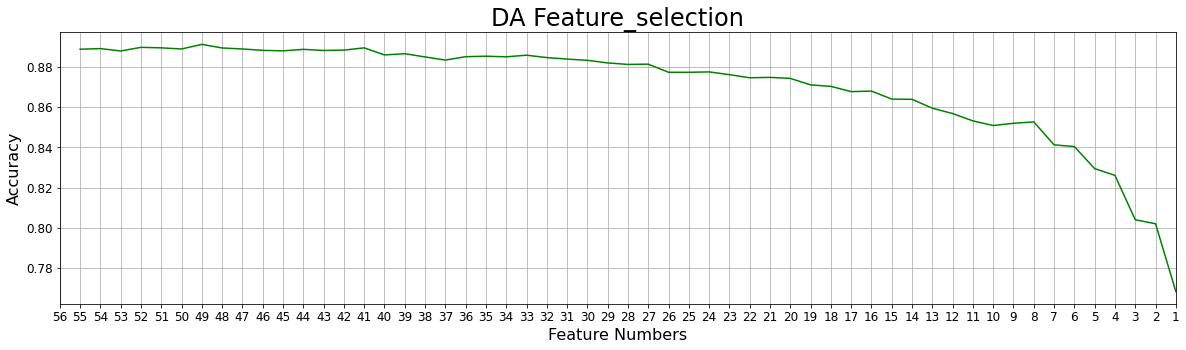

In [83]:
#Plot 并保存gain特征选择结果
plt.figure(figsize=(20, 5))
# x_values=de_fs['feature_num']
# y_values=de_fs['accuracy']
x_values=feature_num
y_values=accuracy_list
plt.plot(x_values,y_values,c='green')
plt.xlim([1, 56])
plt.title(f'{data_name} Feature_selection',fontsize=24)
plt.tick_params(axis='both',which='major',labelsize=12)
plt.xlabel('Feature Numbers',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
x_major_locator=MultipleLocator(1)

ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
ax.invert_xaxis()
plt.grid()
plt.savefig(f'work/results/{data_name}_fs.png')
plt.show() 


还需要输出特征组合
DE1:Thresh=0.008, n=26, Accuracy: 76.52%
DE2:Thresh=0.008, n=14, Accuracy: 76.52%

AN1:Thresh=0.008, n=36, Accuracy: 80%
AN2:Thresh=0.008, n=26, Accuracy: 80%
AN2:n=15,Accuracy: 75%

DE1:Thresh=0.008, n=39, Accuracy: 76.52%

In [46]:
i=2
name_list = ['DE','AN','DA']
data_name = name_list[i]

feature_imp = pd.read_excel(f'work/results/{data_name}_fs_gain.xlsx')
len(feature_imp['var'])

28

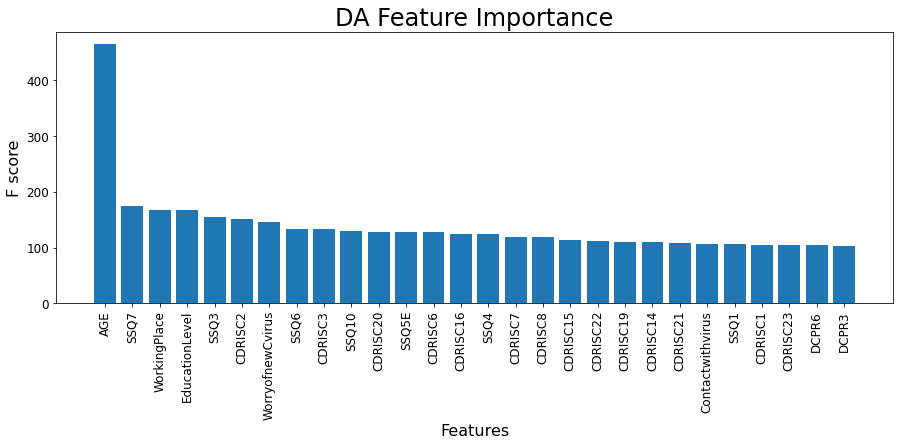

In [47]:
# step3 获取“gain”特征重要性F score
# select_num = 28
select_num = len(feature_imp['var'])
# feature_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
plt.figure(figsize=(15, 5)) 
# x_values=feature_imp.index[0:select_num]
x_values=feature_imp['var']
plt.xticks(rotation=90,fontsize=12)
# y_values=feature_imp.values[0:select_num]
y_values=feature_imp['value']
plt.title(f'{data_name} Feature Importance',fontsize=24)
plt.tick_params(axis='both',which='major',labelsize=12)
plt.xlabel('Features',fontsize=16)
plt.ylabel('F score',fontsize=16)
plt.bar(x_values, y_values)
plt.savefig(f'work/results/{data_name}_feature_importance_gain.png')
plt.show()


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

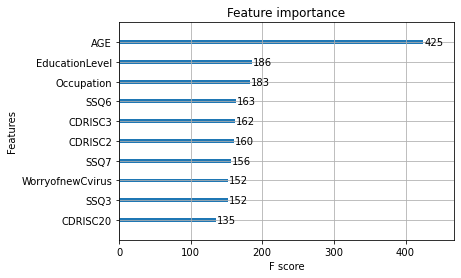

In [36]:
xgb.plot_importance(model,max_num_features=10)

In [62]:
# 保存“gain”特征重要性得分
feature_imp[0:select_num].to_excel(f'work/results/{data_name}_fs_gain.xlsx')

In [ ]:
# step4 获取“weight”特征重要性

im=pd.DataFrame({'importance':model.feature_importances_,'var':df.columns[:-1]})
im=im.sort_values(by='importance',ascending=False)
tops = im.head(select_num)
plt.figure(figsize=(15, 5)) 
x_values=tops['var']
plt.xticks(rotation=90,fontsize=12)
y_values=tops['importance']
plt.title(f'{data_name} Feature Importance',fontsize=24)
plt.tick_params(axis='both',which='major',labelsize=12)
plt.xlabel('Features',fontsize=16)
plt.ylabel('Weight',fontsize=16)
plt.bar(x_values, y_values)
plt.savefig(f'work/results/{data_name}_feature_importance_weight.png')
plt.show()

In [214]:
# 保存“weight”特征重要性结果
result_sum = pd.DataFrame(dict(tops))

result_sum.to_excel(f'work/results/{data_name}_weight.xlsx')

In [ ]:
feature_combine_gain = pd.read_excel('work/results/feature_combine_gain.xlsx')
selected_feat_names = feature_combine_gain['var']
selected_feat_names

In [30]:
#step5 基于“Weight”筛选特征后的预测结果
#交叉验证
for i in range(3):
    df = muti_data[i]
    df = delete_variables(df)
    sample_size = sample_size_list[i]
    X,y = batch_data(df,sample_size)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=7)
    train_new,test_new = feature_selected_data(X_train,y_train,X_test,y_test,selected_feat_names)
    data_new = pd.concat([train_new,test_new])
    X_new = data_new.iloc[:, data_new.columns != 'target']
    y_new = data_new.iloc[:, data_new.columns == 'target']

    model = XGBClassifier(objective ='reg:squarederror')
    # model.fit(X_train, y_train)
    kfold = KFold(n_splits=10, random_state=7,shuffle=True)
    results = cross_val_score(model, X_new, y_new, cv=kfold)
    print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 77.82% (1.74%)
Accuracy: 76.37% (2.07%)
Accuracy: 87.92% (0.77%)


In [ ]:
# Feature_num = 28:
# Accuracy: 77.82% (1.74%)
# Accuracy: 76.37% (2.07%)
# Accuracy: 87.92% (0.77%)

# Feature_num = 20:
# Accuracy: 75.03% (1.20%)
# Accuracy: 75.10% (2.35%)
# Accuracy: 85.61% (0.80%)

# Feature_num = 19:
# Accuracy: 75.43% (1.78%)
# Accuracy: 74.98% (1.50%)
# Accuracy: 85.59% (0.77%)

In [ ]:
# select features using threshold
thresh = 0.00791742093861103
i=2
df = muti_data[i]
df = delete_variables(df)
sample_size = sample_size_list[i]
X,y = batch_data(df,sample_size)
selection = SelectFromModel(model, threshold=thresh, prefit=True)
select_X = selection.transform(X)
# train model
selection_model = XGBClassifier(objective ='reg:squarederror')
kfold = KFold(n_splits=10, random_state=7,shuffle=True)
results = cross_val_score(selection_model, select_X, y, cv=kfold)

In [89]:
# n=28
# Accuracy: 76.14% (0.97%)
# Accuracy: 76.54% (1.82%)
# Accuracy: 86.26% (0.60%)

# n=25
# Accuracy: 75.47% (1.00%)
# Accuracy: 76.62% (2.08%)
# Accuracy: 86.46% (0.84%)

# n=31
# Accuracy: 76.50% (1.34%)
# Accuracy: 75.84% (1.96%)
# Accuracy: 86.39% (1.04%)

In [140]:
#特征选择_PCA（过滤法）
X_train = vec.fit_transform(X_train.to_dict(orient='record'))
X_test = vec.transform(X_test.to_dict(orient='record'))
# 输出处理后特征向量的维度。
print(len(vec.feature_names_))


132


[0.65173587 0.68681558 0.70503065 0.72041581 0.71744631 0.72972492
 0.733907   0.72985878 0.73161526 0.73795849 0.74240966 0.74173489
 0.74187239 0.74969592 0.74497467 0.74983188 0.74753741 0.75212708
 0.75239443 0.75469081]
Optimal number of features 39


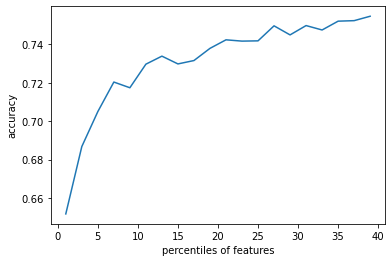

In [173]:
# 通过交叉验证（下一节将详细介绍）的方法，按照固定间隔的百分比筛选特征，并作图展示性能随特征筛选比例的变化。
from sklearn import feature_selection
from sklearn.model_selection import cross_val_score
import numpy as np


percentiles = range(1, 40, 2)
results = []
model = XGBClassifier(objective ='reg:squarederror')
for i in percentiles:
    fs = feature_selection.SelectPercentile(feature_selection.chi2, percentile = i)
    X_train_fs = fs.fit_transform(X_train, y_train)
    scores = cross_val_score(model, X_train_fs, y_train, cv=5)
    results = np.append(results, scores.mean())
print(results)
# 找到体现最佳性能的特征筛选的百分比。
opt = np.where(results == results.max())[0]
print('Optimal number of features %d' %percentiles[int(opt)])
plt.plot(percentiles, results)
plt.xlabel('percentiles of features')
plt.ylabel('accuracy')
plt.show()

In [171]:
#特征选择——包装法
from sklearn.feature_selection import RFE
model = XGBClassifier(objective ='reg:squarederror')
selector = RFE(model, n_features_to_select=40, step=2).fit(X_train, y_train)
X_wrapper_train = selector.transform(X_train)
selection_model = XGBClassifier(objective ='reg:squarederror')
selection_model.fit(X_wrapper_train, y_train)
X_wrapper_test = selector.transform(X_test)
once = cross_val_score(selection_model,X_wrapper_test,y_test,cv=5).mean()
once
# score = []

# for i in range(1,132,1):
#     X_wrapper_train = selector.transform(X_train)
#     selection_model = XGBClassifier(objective ='reg:squarederror')
#     selection_model.fit(X_wrapper_train, y_train)
#     # eval model
#     X_wrapper_test = selector.transform(X_test)
#     once = cross_val_score(selection_model,X_wrapper_test,y_test,cv=5).mean()
#     score.append(once)
# plt.figure(figsize=[20,5])
# plt.plot(range(1,132,1),score)
# plt.xticks(range(1,132,1))
# plt.show()


0.7204604064981425